In [1]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna.samplers import TPESampler

import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import Pipeline

from src.model_validation import TSCrossValidate, summary_evaluation, fold_evaluation
from src.model_helpers import DailyModel
from src.sharpe import score_sharpe
from src.features import FeatureEng

import warnings
warnings.filterwarnings("ignore")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv("data_raw/train.csv")
df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [3]:
solution = df.copy()
market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
market_excess_cumulative = (1 + market_excess_returns).prod()
market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
c = (1 + market_mean_excess_return) ** (1 / (market_excess_returns > 0).mean()) - 1
submission = pd.DataFrame({'prediction': (c / market_excess_returns).clip(0, 2)})
print("best score train:", score_sharpe(solution, submission, ''))

best score train: 16.206165958184915


In [4]:
df["target"] = submission
df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns,target
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038,0.000000
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114,0.000000
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243,0.000000
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046,0.132065
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301,0.000000


In [5]:
TARGET = "target"
DROP = ['is_scored', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns', "target"]
FEATURES = [c for c in df.columns if c not in DROP]

In [6]:
ts_folds = TimeSeriesSplit(n_splits=10, test_size=180)

In [7]:
processing = Pipeline([("imputer", tml.DfImputer(strategy="constant", fill_value=0)), ("scaler", tml.DfScaler())])

In [8]:
def add_streak_features(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Add rolling features counting consecutive positive/negative streaks.
    
    Args:
        df: DataFrame with the column to analyze
        column: Name of the column to track streaks for
    
    Returns:
        DataFrame with added streak columns
    """
    df = df.copy()

    df["temp_col"] = df[column].shift()
    
    # Create binary indicators for positive/negative
    df['_is_positive'] = (df["temp_col"] > 0).astype(int)
    df['_is_negative'] = (df["temp_col"] < 0).astype(int)
    
    # Create streak groups (changes when sign changes)
    df['_pos_streak_group'] = (df['_is_positive'] != df['_is_positive'].shift()).cumsum()
    df['_neg_streak_group'] = (df['_is_negative'] != df['_is_negative'].shift()).cumsum()
    
    # Count consecutive occurrences within each group
    df[f'{column}_positive_streak'] = df.groupby('_pos_streak_group')['_is_positive'].cumsum() * df['_is_positive']
    df[f'{column}_negative_streak'] = df.groupby('_neg_streak_group')['_is_negative'].cumsum() * df['_is_negative']
    
    # Clean up temporary columns
    df = df.drop(columns=['_is_positive', '_is_negative', '_pos_streak_group', '_neg_streak_group', "temp_col"])
    
    return df


def make_lags_train(data):
    df = data.copy()

    targets = ['forward_returns', 'risk_free_rate']

    for col in targets:
        for lag in [1, 5, 22]:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
        
        for w in [5, 22, 220]:
            df[f"{col}_mean_{w}"] = df[col].shift(1).rolling(w, min_periods=w).mean()
            df[f"{col}_std_{w}"] = df[col].shift(1).rolling(w, min_periods=w).std()

        if col == "forward_returns":
            df = add_streak_features(df, col)

    return df

# Linear Model

In [9]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "alpha": trial.suggest_float("alpha", 1, 100),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.1, 1),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            ("scaler", tml.DfScaler())])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = ElasticNet(alpha=param["alpha"], l1_ratio=param["l1_ratio"], random_state=325)

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"], 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [10]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2025-12-03 18:03:57,292] A new study created in memory with name: no-name-8fbdb042-c095-40ef-b77c-c384f791b53e


Number of finished trials: 200
Best trial: {'alpha': 49.40365089416544, 'l1_ratio': 0.7796297720909481, 'strategy': 'mean', 'sample_weight': True, 'u1': False, 'u2': False, 'add_ts': False, 'riskadj_m4': False, 'quant_p11': True, 'fed_model': False, 'glob_vol': True, 'relmom': False, 'mom_div': False, 'mompersistence': False, 'mom_regime': True, 'vol_spread': False, 'price_mom': False, 'rate_sens': True}


In [11]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_add_ts,params_alpha,params_fed_model,params_glob_vol,params_l1_ratio,...,params_quant_p11,params_rate_sens,params_relmom,params_riskadj_m4,params_sample_weight,params_strategy,params_u1,params_u2,params_vol_spread,state
184,184,0.379505,2025-12-03 18:07:53.824441,2025-12-03 18:08:13.447027,0 days 00:00:19.622586,False,85.561065,True,False,0.311706,...,True,False,True,True,True,median,False,True,False,COMPLETE
185,185,0.379505,2025-12-03 18:07:54.812624,2025-12-03 18:08:15.448898,0 days 00:00:20.636274,False,17.694202,True,False,0.650262,...,True,False,True,True,True,median,False,True,False,COMPLETE
186,186,0.379505,2025-12-03 18:07:54.961721,2025-12-03 18:08:15.649312,0 days 00:00:20.687591,False,97.546704,True,False,0.651623,...,True,False,True,False,True,median,False,True,True,COMPLETE
187,187,0.379505,2025-12-03 18:07:55.474040,2025-12-03 18:08:17.156994,0 days 00:00:21.682954,False,47.712543,True,False,0.644413,...,True,False,True,True,True,median,False,True,True,COMPLETE
188,188,0.379505,2025-12-03 18:08:00.178245,2025-12-03 18:08:19.699051,0 days 00:00:19.520806,False,98.227305,True,False,0.695023,...,True,False,True,True,True,median,False,True,False,COMPLETE
189,189,0.379505,2025-12-03 18:08:00.301238,2025-12-03 18:08:20.350663,0 days 00:00:20.049425,False,96.040174,True,False,0.692287,...,True,False,True,True,True,median,False,True,False,COMPLETE
190,190,0.379505,2025-12-03 18:08:03.848312,2025-12-03 18:08:22.700666,0 days 00:00:18.852354,False,47.371327,True,False,0.614340,...,True,False,True,True,True,median,False,True,False,COMPLETE
191,191,0.379505,2025-12-03 18:08:03.993196,2025-12-03 18:08:22.100162,0 days 00:00:18.106966,False,47.219018,True,False,0.700591,...,True,True,True,True,True,median,False,True,False,COMPLETE
8,8,0.379505,2025-12-03 18:03:57.304376,2025-12-03 18:04:14.695773,0 days 00:00:17.391397,False,31.380381,False,True,0.219215,...,True,True,True,False,True,constant,True,False,False,COMPLETE
9,9,0.379505,2025-12-03 18:03:57.305722,2025-12-03 18:04:22.862248,0 days 00:00:25.556526,True,85.857801,True,True,0.250460,...,True,True,True,True,True,mean,False,False,True,COMPLETE


In [12]:
optuna.visualization.plot_optimization_history(study)

In [13]:
optuna.visualization.plot_param_importances(study)

Mean Squared Error: 0.00012
R2: -0.0002802998318685024
MAE: 0.007926483420219316
               min      mean       max
fold                                  
0     1.128986e-09  0.000110  0.001546
1     3.756913e-10  0.000061  0.000928
2     2.868247e-09  0.000322  0.001625
3     6.450893e-10  0.000079  0.001192
4     4.656548e-10  0.000103  0.000891
5     4.027684e-10  0.000246  0.001643
6     1.918253e-09  0.000078  0.000624
7     6.923932e-12  0.000054  0.000406
8     6.187906e-10  0.000069  0.000920
9     5.237794e-10  0.000117  0.001651
Sharpe: 0.6406138329391244
0 -0.223030977633935
1 1.6085672096963926
2 0.6296779306039075
3 2.478625781847355
4 0.41391984750396926
5 -0.8081853233853052
6 0.9798122875098716
7 1.6283334390047337
8 1.0719220611164577
9 0.614819316362808


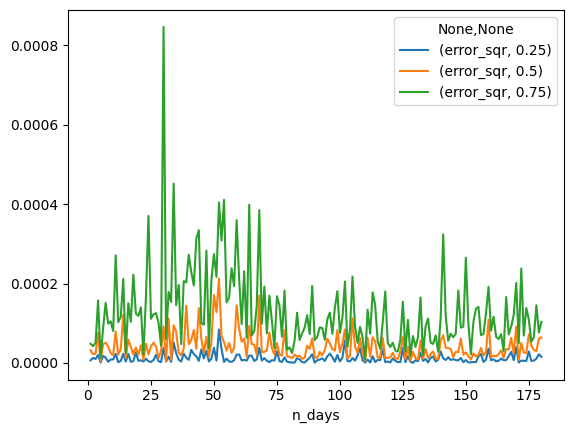

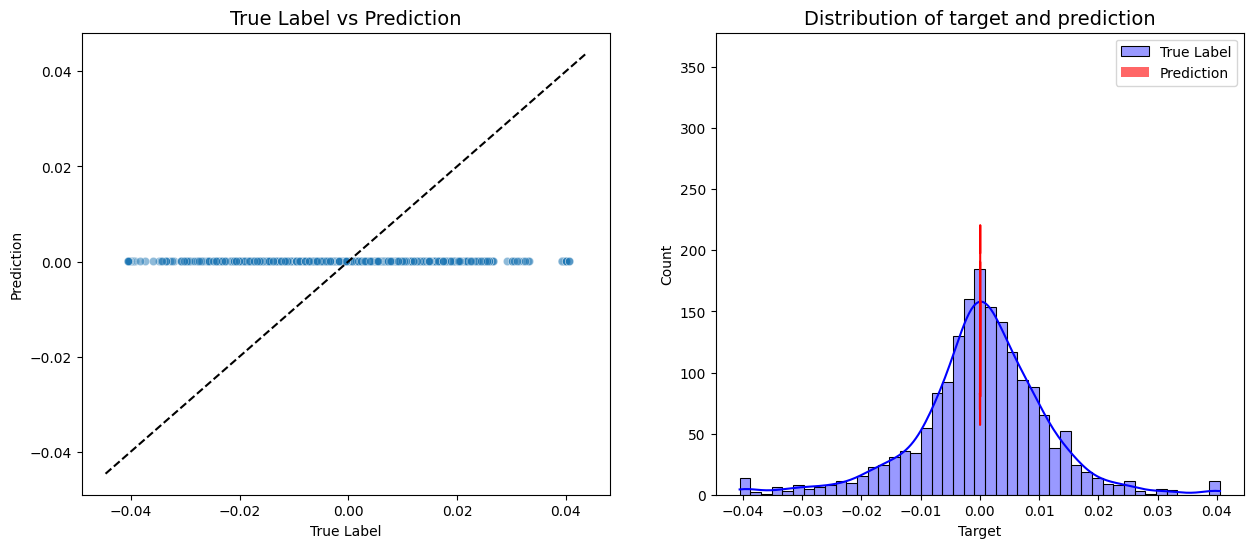

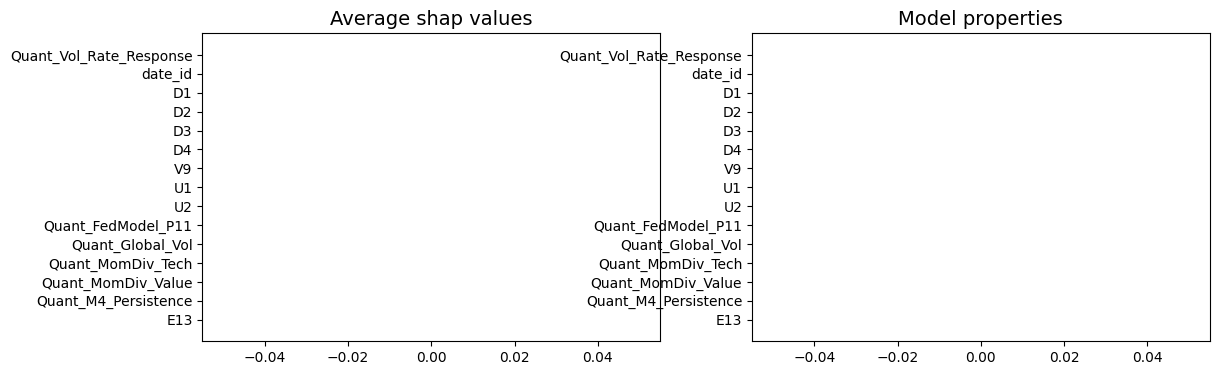

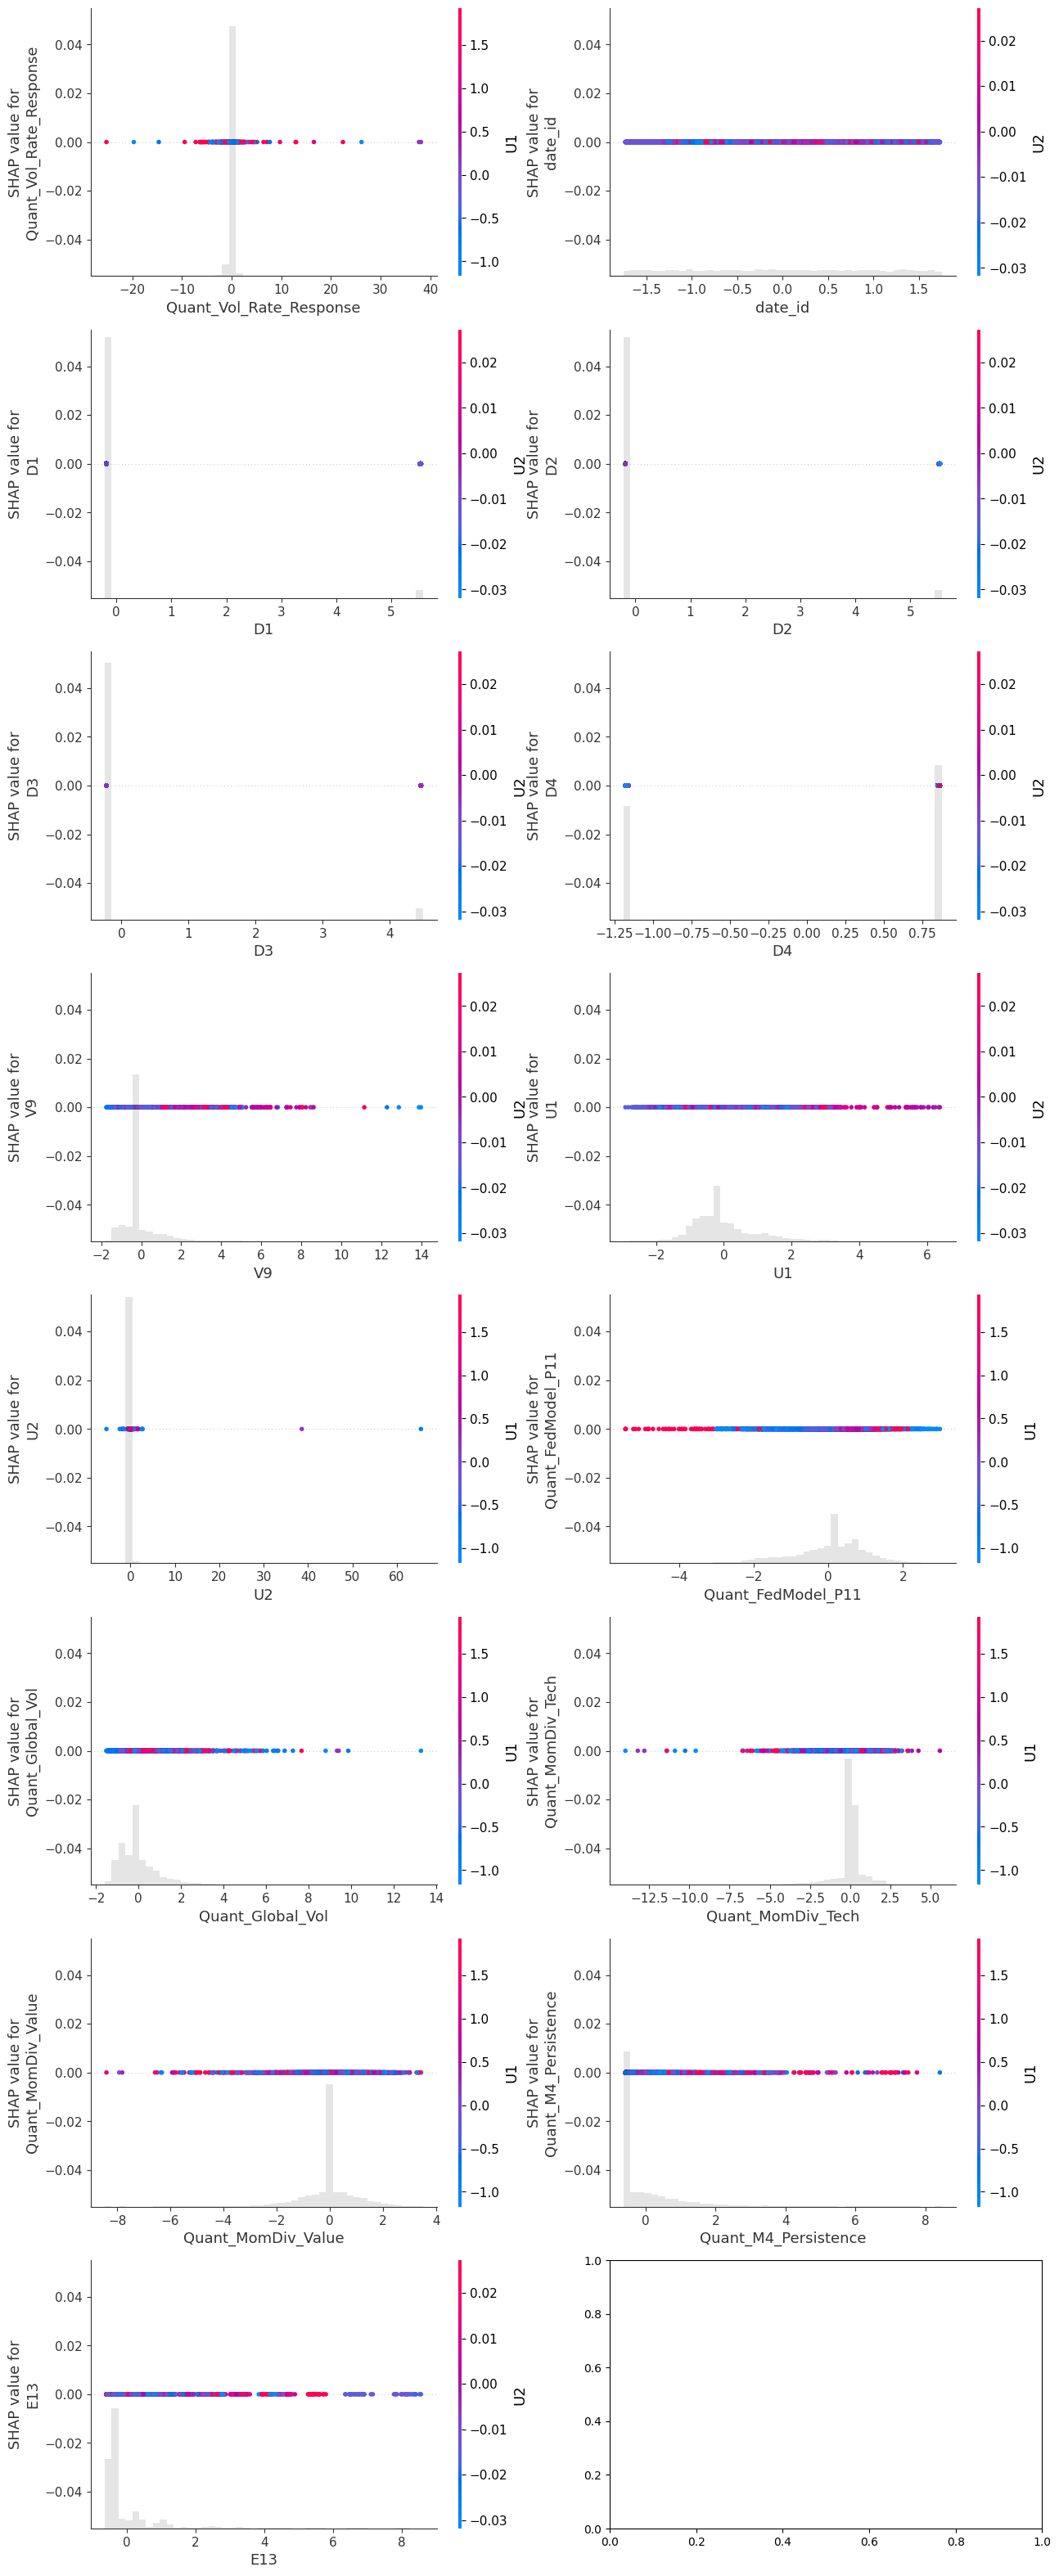

In [31]:
model = ElasticNet(alpha=51, l1_ratio=0.47, random_state=325)

processing = Pipeline([("fe", FeatureEng(u1=True, u2=True, add_ts=False,
                                             riskadj_m4=False, quant_p11=False, fed_model=True,
                                             glob_vol=True, relmom=False, mom_div=True,
                                             mompersistence=True, momregime=True, vol_spread=True,
                                             price_mom=True, rate_sens=True)),
                            ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                            ("scaler", tml.DfScaler())])

pipe = Pipeline([("processing", processing),
                ("model", model)])

fit_params = {"sample_weight": "date_id"}


FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"], df, factor=1)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(15)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

# RandomForest

In [15]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", 0.8]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "create_features": trial.suggest_categorical("create_features", [True, False]),
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1, n_estimators=150,
                                          max_features=param["max_features"],
                                          min_samples_leaf=param["min_samples_leaf"])

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id"}
    else:
        fit_params = {}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"], 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [ ]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_add_ts,params_conversion,params_create_features,params_fed_model,params_glob_vol,...,params_quant_p11,params_rate_sens,params_relmom,params_riskadj_m4,params_sample_weight,params_strategy,params_u1,params_u2,params_vol_spread,state
160,160,0.638961,2025-11-30 16:55:00.408885,2025-11-30 17:01:22.973574,0 days 00:06:22.564689,True,3,False,False,True,...,True,False,False,True,True,constant,False,False,True,COMPLETE
106,106,0.638818,2025-11-30 16:44:01.641630,2025-11-30 16:46:28.398272,0 days 00:02:26.756642,True,3,False,False,False,...,True,False,True,True,True,median,False,False,False,COMPLETE
97,97,0.638527,2025-11-30 16:42:42.473529,2025-11-30 16:46:20.916565,0 days 00:03:38.443036,True,6,False,False,True,...,True,False,False,True,True,median,False,False,True,COMPLETE
108,108,0.637841,2025-11-30 16:44:45.452551,2025-11-30 16:46:41.034978,0 days 00:01:55.582427,True,9,False,True,False,...,True,False,True,True,True,constant,False,False,False,COMPLETE
175,175,0.637365,2025-11-30 16:59:23.503559,2025-11-30 17:05:18.578014,0 days 00:05:55.074455,False,5,True,True,True,...,False,False,True,False,True,mean,True,True,True,COMPLETE
170,170,0.635863,2025-11-30 16:55:57.223442,2025-11-30 17:02:01.243897,0 days 00:06:04.020455,False,7,True,True,True,...,False,False,True,False,True,mean,True,True,True,COMPLETE
174,174,0.635863,2025-11-30 16:59:19.440104,2025-11-30 17:05:13.978491,0 days 00:05:54.538387,False,7,True,True,True,...,False,False,True,False,True,mean,True,True,True,COMPLETE
107,107,0.635622,2025-11-30 16:44:23.378794,2025-11-30 16:46:34.534773,0 days 00:02:11.155979,True,16,True,True,False,...,True,False,True,True,True,constant,False,False,False,COMPLETE
176,176,0.635218,2025-11-30 17:01:22.143679,2025-11-30 17:07:16.251472,0 days 00:05:54.107793,False,15,True,True,True,...,False,False,True,False,True,mean,True,True,True,COMPLETE
102,102,0.634911,2025-11-30 16:43:04.408451,2025-11-30 16:46:03.455895,0 days 00:02:59.047444,True,12,False,False,False,...,True,False,False,True,True,median,False,False,False,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

Mean Squared Error: 0.00013
R2: -0.019060410010521833
MAE: 0.007986276357873037
               min      mean       max
fold                                  
0     3.391471e-11  0.000115  0.001158
1     6.851690e-11  0.000059  0.000980
2     2.038399e-13  0.000326  0.002171
3     2.823110e-10  0.000082  0.001214
4     2.381160e-10  0.000104  0.001082
5     2.083973e-10  0.000248  0.001736
6     6.158287e-09  0.000083  0.000527
7     4.939820e-10  0.000055  0.000399
8     2.195047e-09  0.000068  0.000934
9     9.959229e-11  0.000121  0.001990
Sharpe: 0.6391502366980117
0 -0.22247579165788886
1 1.6150137176327481
2 0.6281405934101986
3 2.478124064153485
4 0.41739730453363205
5 -0.8056640474238238
6 0.982017248203597
7 1.6277836412321323
8 1.074207555496684
9 0.6079765417532557


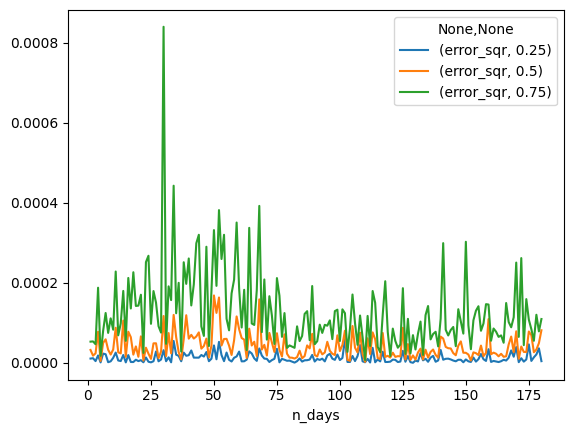

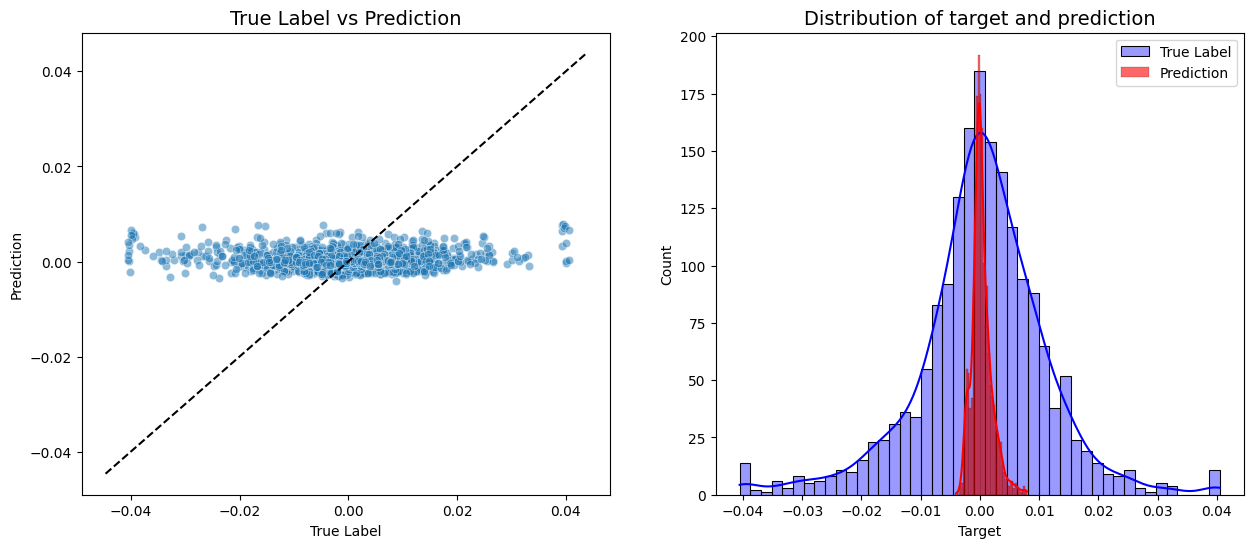

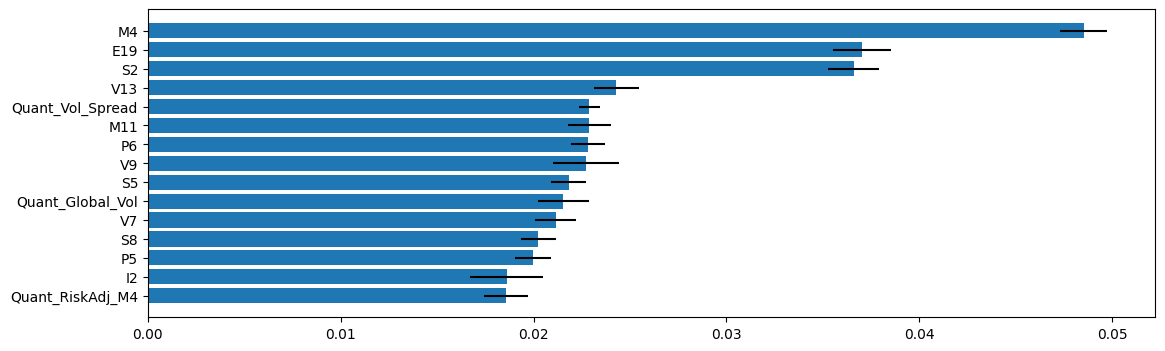

In [34]:
model = RandomForestRegressor(max_depth=20, random_state=34, n_jobs=-1, max_features=0.8, min_samples_leaf=37, n_estimators=150)

processing = Pipeline([("fe", FeatureEng(u1=False, u2=False, add_ts=True,
                                             riskadj_m4=True, quant_p11=True, fed_model=False,
                                             glob_vol=True, relmom=False, mom_div=False,
                                             mompersistence=True, momregime=False, vol_spread=True,
                                             price_mom=False, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

fit_params = {"sample_weight": "date_id"}


FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, imp_coef=True, fit_params=fit_params)
oof, res = cvscore.score()

summary_evaluation(res["folds_eval"], df, factor=3)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="standard")

# Xgboost

In [ ]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = xgb.XGBRegressor(random_state=34, n_jobs=-1, early_stopping_rounds=100,
                             learning_rate=0.01,
                             n_estimators=10000,
                             subsample=param["subsample"],
                             colsample_bytree=param["colsample_bytree"],
                             reg_alpha=param["reg_alpha"],
                             reg_lambda=param["reg_lambda"],
                             max_depth=param["max_depth"],
                             colsample_bylevel=param["colsample_bylevel"],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", 'verbose': False,}
    else:
        fit_params = {'verbose': False,}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"], 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [ ]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'create_features': True, 'strategy': 'constant', 'sample_weight': True, 'conversion': 200, 'max_depth': 128, 'reg_lambda': 99.28850676439117, 'reg_alpha': 97.43511668291023, 'colsample_bytree': 0.934447653509793, 'colsample_bylevel': 0.5916504530610037, 'subsample': 0.9984747726743173, 'min_child_weight': 64.90828239276584, 'u1': False, 'u2': False, 'add_ts': True, 'riskadj_m4': False, 'quant_p11': True, 'fed_model': True, 'glob_vol': True, 'relmom': True, 'mom_div': False, 'mompersistence': True, 'mom_regime': True, 'vol_spread': False, 'price_mom': True, 'rate_sens': True}


In [ ]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_add_ts,params_colsample_bylevel,params_colsample_bytree,params_conversion,params_create_features,...,params_reg_lambda,params_relmom,params_riskadj_m4,params_sample_weight,params_strategy,params_subsample,params_u1,params_u2,params_vol_spread,state
26,26,0.984893,2025-11-30 17:13:03.619220,2025-11-30 17:20:03.925861,0 days 00:07:00.306641,True,0.591650,0.934448,200,True,...,99.288507,True,False,True,constant,0.998475,False,False,False,COMPLETE
125,125,0.968376,2025-11-30 17:49:50.190987,2025-11-30 17:56:58.846797,0 days 00:07:08.655810,True,0.382600,0.825113,984,True,...,57.186744,True,False,True,constant,0.465559,False,False,True,COMPLETE
170,170,0.895196,2025-11-30 18:07:48.821417,2025-11-30 18:14:27.708205,0 days 00:06:38.886788,False,0.910541,0.763940,892,True,...,83.566869,True,False,True,mean,0.449017,True,False,False,COMPLETE
152,152,0.879781,2025-11-30 17:59:32.415870,2025-11-30 18:07:48.820895,0 days 00:08:16.405025,False,0.985290,0.767922,596,True,...,57.787886,False,False,True,constant,0.850882,False,False,True,COMPLETE
39,39,0.876875,2025-11-30 17:18:33.582170,2025-11-30 17:23:50.564603,0 days 00:05:16.982433,True,0.390879,0.840773,1211,True,...,75.672498,True,False,False,constant,0.874077,False,False,True,COMPLETE
140,140,0.851087,2025-11-30 17:55:42.055140,2025-11-30 18:01:29.005209,0 days 00:05:46.950069,True,0.301610,0.840408,590,True,...,73.031136,True,False,True,mean,0.441006,True,False,False,COMPLETE
54,54,0.833052,2025-11-30 17:20:49.085097,2025-11-30 17:27:47.893830,0 days 00:06:58.808733,True,0.570112,0.577152,985,True,...,48.434967,True,False,True,constant,0.718584,False,False,True,COMPLETE
150,150,0.826543,2025-11-30 17:58:59.069560,2025-11-30 18:03:30.942039,0 days 00:04:31.872479,False,0.954825,0.760022,590,True,...,98.584204,False,False,True,constant,0.437891,False,False,True,COMPLETE
74,74,0.816421,2025-11-30 17:30:19.545465,2025-11-30 17:31:11.656091,0 days 00:00:52.110626,True,0.628631,0.664785,1713,True,...,42.637901,True,False,True,mean,0.545948,True,False,False,COMPLETE
1,1,0.797435,2025-11-30 17:11:46.761788,2025-11-30 17:19:56.068656,0 days 00:08:09.306868,True,0.957562,0.852610,198,True,...,98.983727,True,False,True,mean,0.655658,True,False,False,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Mean Squared Error: 0.00013
R2: -0.06528136468493417
MAE: 0.008205695012569729
               min      mean       max
fold                                  
0     1.246097e-11  0.000116  0.002223
1     1.384532e-09  0.000062  0.001081
2     4.152906e-09  0.000327  0.002518
3     7.263032e-11  0.000082  0.001195
4     1.716503e-09  0.000105  0.000994
5     5.179064e-09  0.000278  0.002222
6     2.138986e-09  0.000090  0.000710
7     7.165207e-12  0.000058  0.000444
8     6.148761e-09  0.000075  0.001081
9     7.401948e-10  0.000127  0.002608
Sharpe: 0.4505258031810035
0 -0.21080407668665793
1 1.6465870309934745
2 1.1933960022623475
3 2.637722796907636
4 0.6819209888625818
5 -0.09838553676242848
6 0.8241936983615962
7 1.5310097258675017
8 0.4385757325261621
9 0.3385286516712345


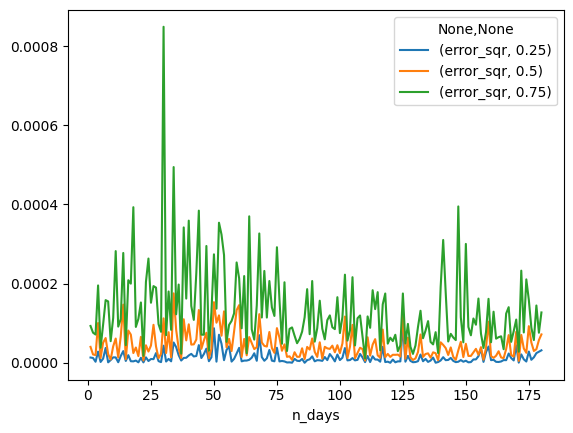

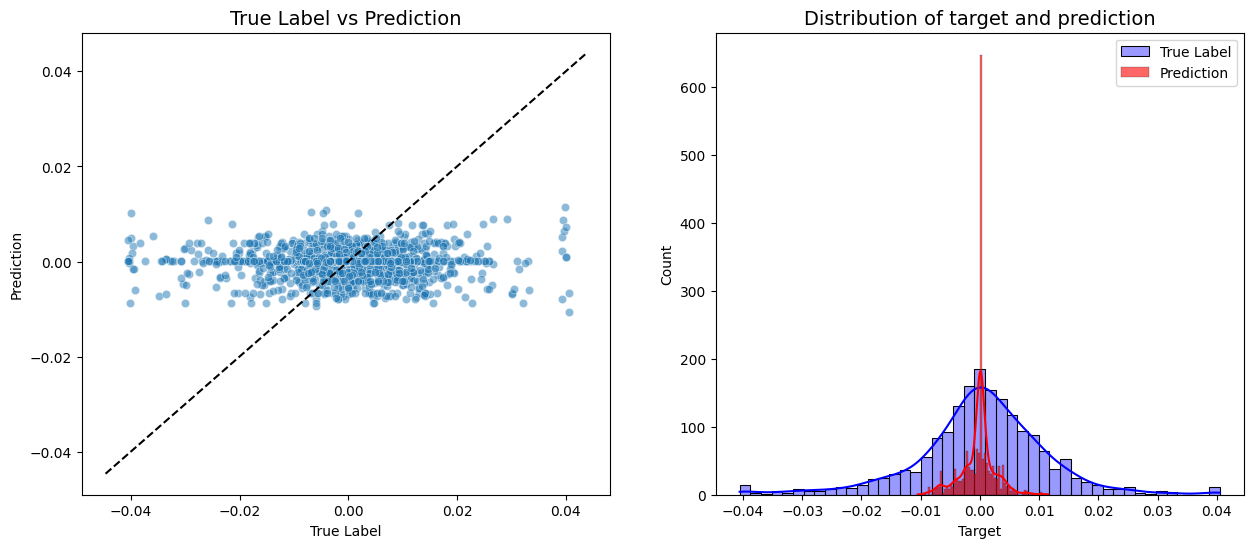

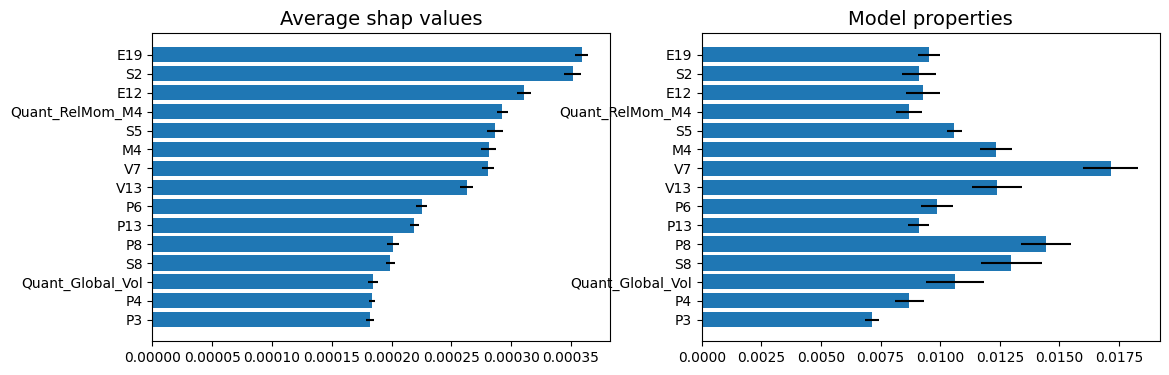

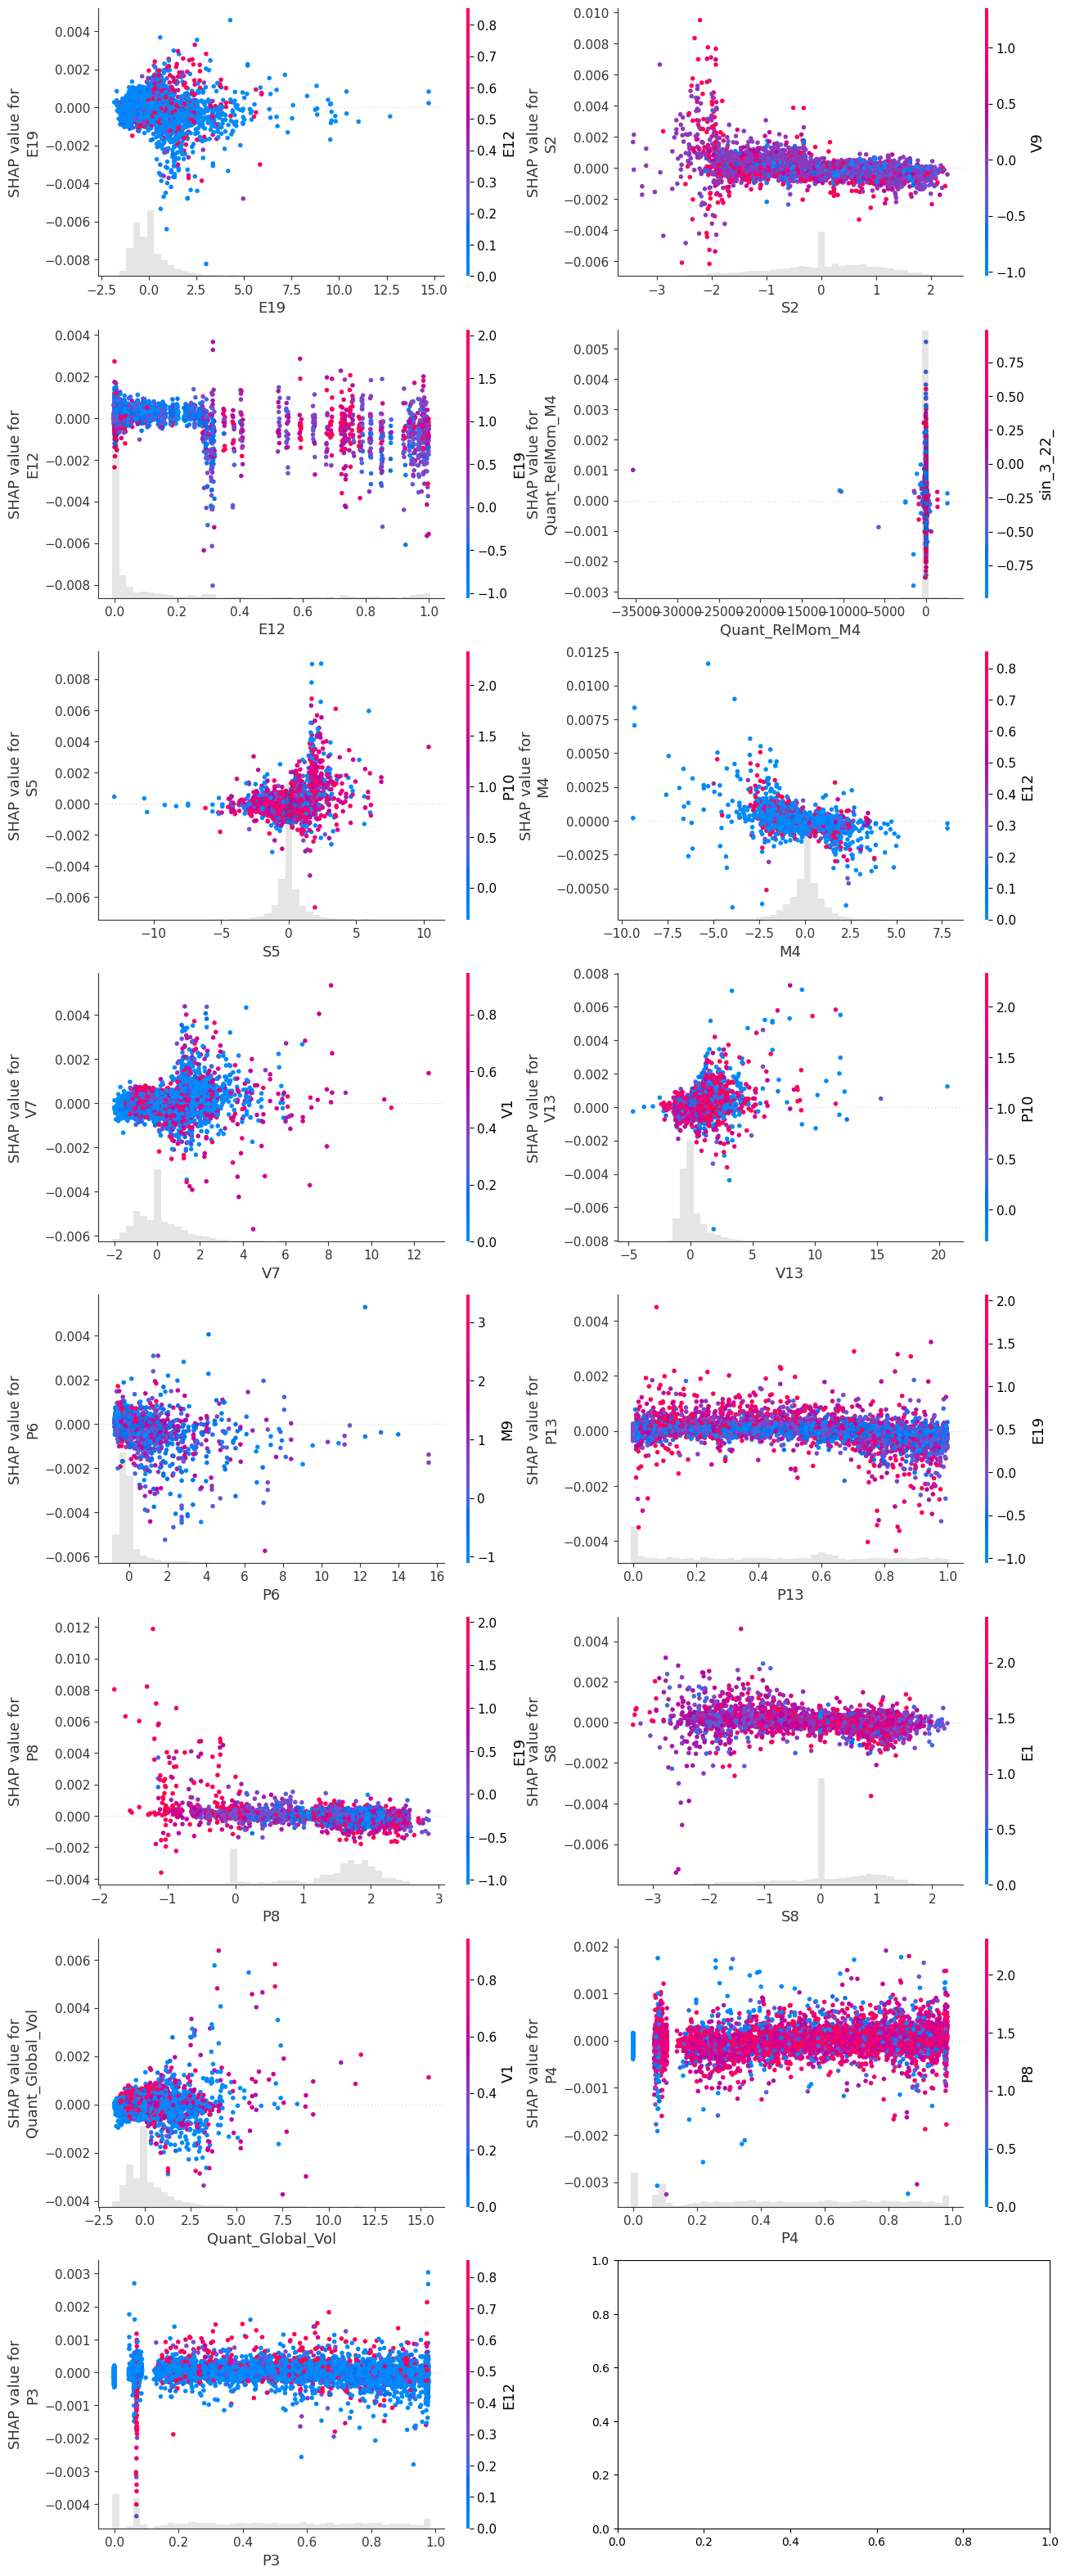

In [37]:
model = xgb.XGBRegressor(random_state=34, n_jobs=-1,
                         early_stopping_rounds=100,
                         n_estimators=10000,
                         colsample_bylevel=0.59,
                         colsample_bytree=0.93,
                         max_depth=128,
                         min_child_weight=65,
                         reg_alpha=97,
                         reg_lambda=99,
                        #  subsample=0.427,
                         eval_metric="rmse")

fit_params = {'verbose': False, "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng(u1=False, u2=False, add_ts=True,
                                             riskadj_m4=False, quant_p11=True, fed_model=True,
                                             glob_vol=True, relmom=True, mom_div=False,
                                             mompersistence=True, momregime=True, vol_spread=False,
                                             price_mom=True, rate_sens=True)),
                            ("imputer", tml.DfImputer(strategy="constant", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=200)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(15)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)

# Light GBM

In [11]:
def objective(trial, data=df, target=df[TARGET]):
    param = {
        "strategy": trial.suggest_categorical("strategy", ["constant", "mean", "median"]),
        "sample_weight": trial.suggest_categorical("sample_weight", [True, False]),
        # "conversion": trial.suggest_int("conversion", 1, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 300),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 100.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 100.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3 , 300),
        "u1": trial.suggest_categorical("u1", [True, False]),
        "u2": trial.suggest_categorical("u2", [True, False]),
        "add_ts": trial.suggest_categorical("add_ts", [True, False]),
        "riskadj_m4": trial.suggest_categorical("riskadj_m4", [True, False]),
        "quant_p11": trial.suggest_categorical("quant_p11", [True, False]),
        "fed_model": trial.suggest_categorical("fed_model", [True, False]),
        "glob_vol": trial.suggest_categorical("glob_vol", [True, False]),
        "relmom": trial.suggest_categorical("relmom", [True, False]),
        "mom_div": trial.suggest_categorical("mom_div", [True, False]),
        "mompersistence": trial.suggest_categorical("mompersistence", [True, False]),
        "mom_regime": trial.suggest_categorical("mom_regime", [True, False]),
        "vol_spread": trial.suggest_categorical("vol_spread", [True, False]),
        "price_mom": trial.suggest_categorical("price_mom", [True, False]),
        "rate_sens": trial.suggest_categorical("rate_sens", [True, False]),
    }
    processing = Pipeline([("fe", FeatureEng(u1=param["u1"], u2=param["u2"], add_ts=param["add_ts"],
                                             riskadj_m4=param["riskadj_m4"], quant_p11=param["quant_p11"], fed_model=param["fed_model"],
                                             glob_vol=param["glob_vol"], relmom=param["relmom"], mom_div=param["mom_div"],
                                             mompersistence=param["mompersistence"], momregime=param["mom_regime"], vol_spread=param["vol_spread"],
                                             price_mom=param["price_mom"], rate_sens=param["rate_sens"])),
                            ("imputer", tml.DfImputer(strategy=param["strategy"], fill_value=0)),
                            # ("scaler", tml.DfScaler())
                            ])
    
    train = make_lags_train(data)

    FEATURES = [c for c in train.columns if c not in DROP]
    
    model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                             colsample_bytree=param["colsample_bytree"],
                             min_child_weight=param['min_child_weight'],
                             reg_lambda=param['reg_lambda'],
                             reg_alpha=param['reg_alpha'],
                             subsample=param['subsample'],
                             num_leaves=param["num_leaves"],
                             max_depth=param['max_depth'],
                             eval_metric="rmse")

    pipe = Pipeline([("processing", processing),
                    ("model", model)])
    
    callbacks = [lgb.early_stopping(100, verbose=0)]
    
    if param["sample_weight"]:
        fit_params = {"sample_weight": "date_id", "callbacks":callbacks, "eval_metric": "rmse"}
    else:
        fit_params = {"callbacks":callbacks, "eval_metric": "rmse"}

    cvscore = TSCrossValidate(data=train[FEATURES], target=target, cv=ts_folds, estimator=pipe, fit_params=fit_params, early_stopping=True)
    oof, res = cvscore.score()

    sub = res["folds_eval"].copy()
    sub["prediction"] = np.clip(sub["predictions"], 0, 2)
    sharpe = score_sharpe(solution=df[df["date_id"] >= sub["date_id"].min()].reset_index(drop=True), submission=sub, row_id_column_name='')
    
    return sharpe

In [12]:
sampler = TPESampler(seed=645)  # Make the sampler behave in a deterministic way.

study = optuna.create_study(direction='maximize', sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=200, n_jobs=-1)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 200
Best trial: {'strategy': 'constant', 'sample_weight': True, 'max_depth': 31, 'num_leaves': 140, 'reg_lambda': 97.53941998456662, 'reg_alpha': 54.0590610441347, 'colsample_bytree': 0.47709826918363885, 'subsample': 0.7171766441510157, 'min_child_weight': 221.63309649907427, 'u1': False, 'u2': False, 'add_ts': True, 'riskadj_m4': False, 'quant_p11': False, 'fed_model': True, 'glob_vol': False, 'relmom': True, 'mom_div': True, 'mompersistence': False, 'mom_regime': False, 'vol_spread': True, 'price_mom': False, 'rate_sens': True}


In [13]:
study.trials_dataframe().sort_values('value', ascending=False).head(10)

,number,value,datetime_start,datetime_complete,duration,params_add_ts,params_colsample_bytree,params_fed_model,params_glob_vol,params_max_depth,...,params_reg_lambda,params_relmom,params_riskadj_m4,params_sample_weight,params_strategy,params_subsample,params_u1,params_u2,params_vol_spread,state
24,24,0.528420,2025-12-03 22:41:59.234446,2025-12-03 22:46:48.740363,0 days 00:04:49.505917,True,0.477098,True,False,31,...,97.539420,True,False,True,constant,0.717177,False,False,True,COMPLETE
159,159,0.527247,2025-12-03 23:13:19.590306,2025-12-03 23:16:02.266328,0 days 00:02:42.676022,False,0.735481,True,True,59,...,88.874287,True,False,True,mean,0.704059,False,False,True,COMPLETE
137,137,0.524674,2025-12-03 23:08:48.153746,2025-12-03 23:11:21.111658,0 days 00:02:32.957912,False,0.492865,True,False,63,...,98.047041,True,False,True,mean,0.834581,False,False,True,COMPLETE
138,138,0.522431,2025-12-03 23:08:47.166293,2025-12-03 23:13:48.520239,0 days 00:05:01.353946,False,0.484444,True,False,64,...,99.593606,True,False,True,mean,0.861472,False,False,True,COMPLETE
70,70,0.521354,2025-12-03 22:52:37.191269,2025-12-03 22:57:02.923857,0 days 00:04:25.732588,True,0.568762,False,True,89,...,8.324181,True,True,True,mean,0.708422,False,False,True,COMPLETE
46,46,0.516477,2025-12-03 22:46:25.733927,2025-12-03 22:51:20.102471,0 days 00:04:54.368544,False,0.502384,False,True,55,...,18.298253,True,False,True,mean,0.846978,False,False,False,COMPLETE
162,162,0.516409,2025-12-03 23:13:48.521114,2025-12-03 23:18:46.190334,0 days 00:04:57.669220,False,0.531076,True,False,277,...,47.060321,True,False,True,mean,0.701339,False,False,True,COMPLETE
131,131,0.509925,2025-12-03 23:07:31.179032,2025-12-03 23:09:45.007020,0 days 00:02:13.827988,False,0.634487,True,False,33,...,91.940626,True,False,True,mean,0.681290,True,True,False,COMPLETE
119,119,0.507376,2025-12-03 23:04:37.585776,2025-12-03 23:07:27.539315,0 days 00:02:49.953539,False,0.416470,True,False,194,...,96.772898,True,False,True,mean,0.770942,True,True,False,COMPLETE
71,71,0.504405,2025-12-03 22:52:48.193763,2025-12-03 22:58:08.816400,0 days 00:05:20.622637,True,0.586035,False,True,92,...,25.616764,True,False,True,mean,0.922990,False,False,True,COMPLETE


In [14]:
optuna.visualization.plot_optimization_history(study)

In [15]:
optuna.visualization.plot_param_importances(study)

In [38]:
{'sample_weight': True, 'conversion': 555, 'max_depth': 130, 'num_leaves': 71, 'reg_lambda': 81.19443082823251, 'reg_alpha': 79.18742491005827, 'colsample_bytree': 0.7112948463708316, 'subsample': 0.6740074826724569, 'min_child_weight': 57.50100690155361, 'u1': False, 'u2': False, 'add_ts': False, 'riskadj_m4': True, 'quant_p11': False, 'fed_model': True, 'glob_vol': False, 'relmom': True, 'mom_div': False, 'mompersistence': False, 'mom_regime': True, 'vol_spread': True, 'price_mom': True, 'rate_sens': False}

{'sample_weight': True,
 'conversion': 555,
 'max_depth': 130,
 'num_leaves': 71,
 'reg_lambda': 81.19443082823251,
 'reg_alpha': 79.18742491005827,
 'colsample_bytree': 0.7112948463708316,
 'subsample': 0.6740074826724569,
 'min_child_weight': 57.50100690155361,
 'u1': False,
 'u2': False,
 'add_ts': False,
 'riskadj_m4': True,
 'quant_p11': False,
 'fed_model': True,
 'glob_vol': False,
 'relmom': True,
 'mom_div': False,
 'mompersistence': False,
 'mom_regime': True,
 'vol_spread': True,
 'price_mom': True,
 'rate_sens': False}

[5, 146, 108, 1, 8, 1, 35, 1, 2, 10]
Mean Squared Error: 0.00012
R2: 0.004325351695513624
MAE: 0.00790294149644556
               min      mean       max
fold                                  
0     6.053239e-11  0.000110  0.001482
1     6.669296e-10  0.000060  0.000904
2     1.743704e-08  0.000318  0.002001
3     9.228888e-10  0.000079  0.001195
4     8.813900e-11  0.000102  0.000897
5     1.502702e-08  0.000246  0.001650
6     4.844066e-09  0.000078  0.000586
7     1.158506e-10  0.000054  0.000404
8     6.732236e-11  0.000069  0.000922
9     1.088017e-10  0.000117  0.001697
Sharpe: 0.7075858555501493
0 -0.19889575116022773
1 1.386347761403773
2 0.7756920720696804
3 2.510916516050628
4 0.5265494549664874
5 -0.7543803336087544
6 1.5598763547014602
7 1.6166802119402146
8 1.0909419488341572
9 0.5548506780766832


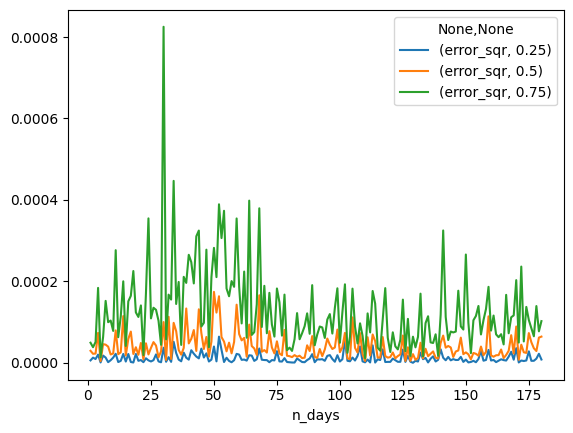

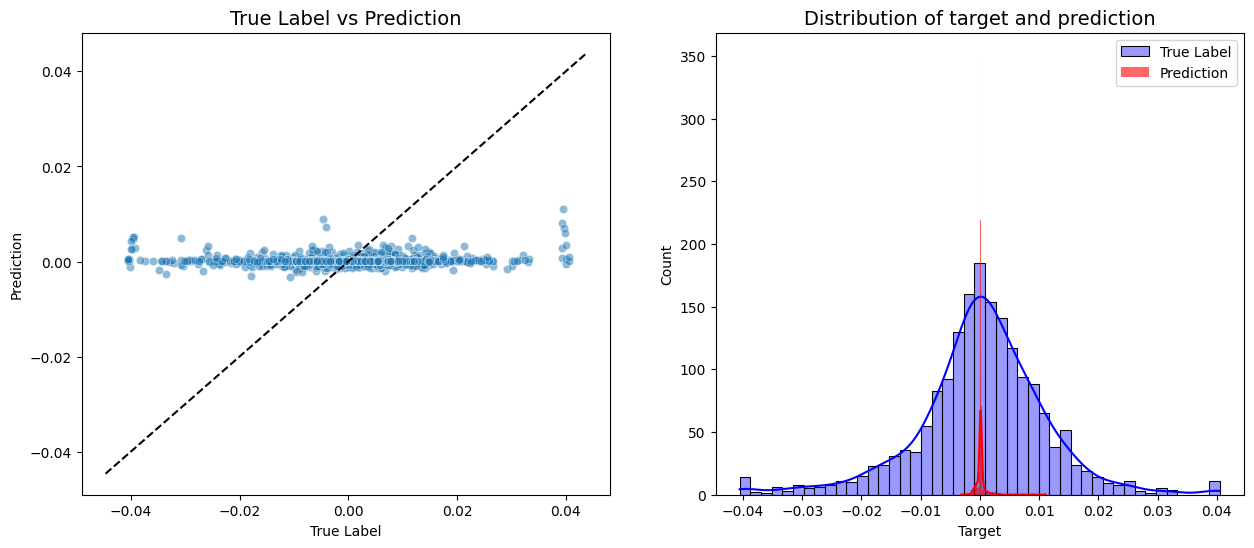

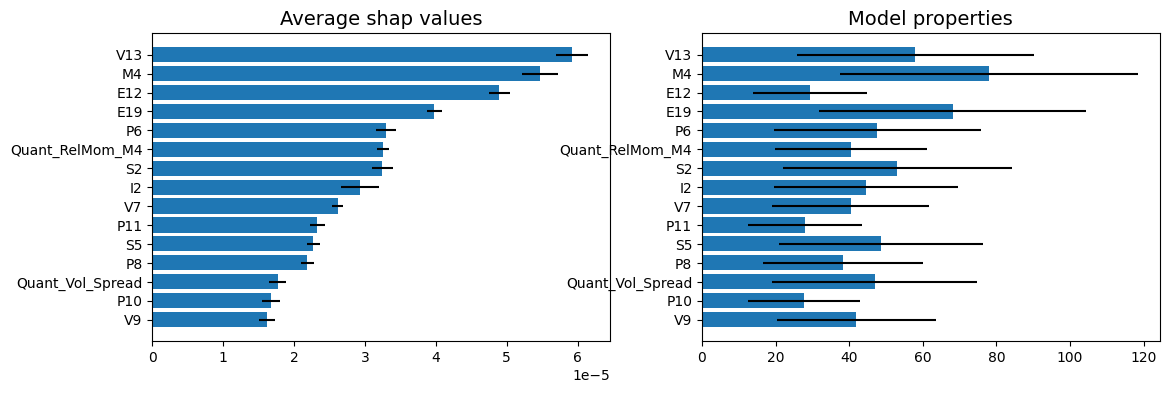

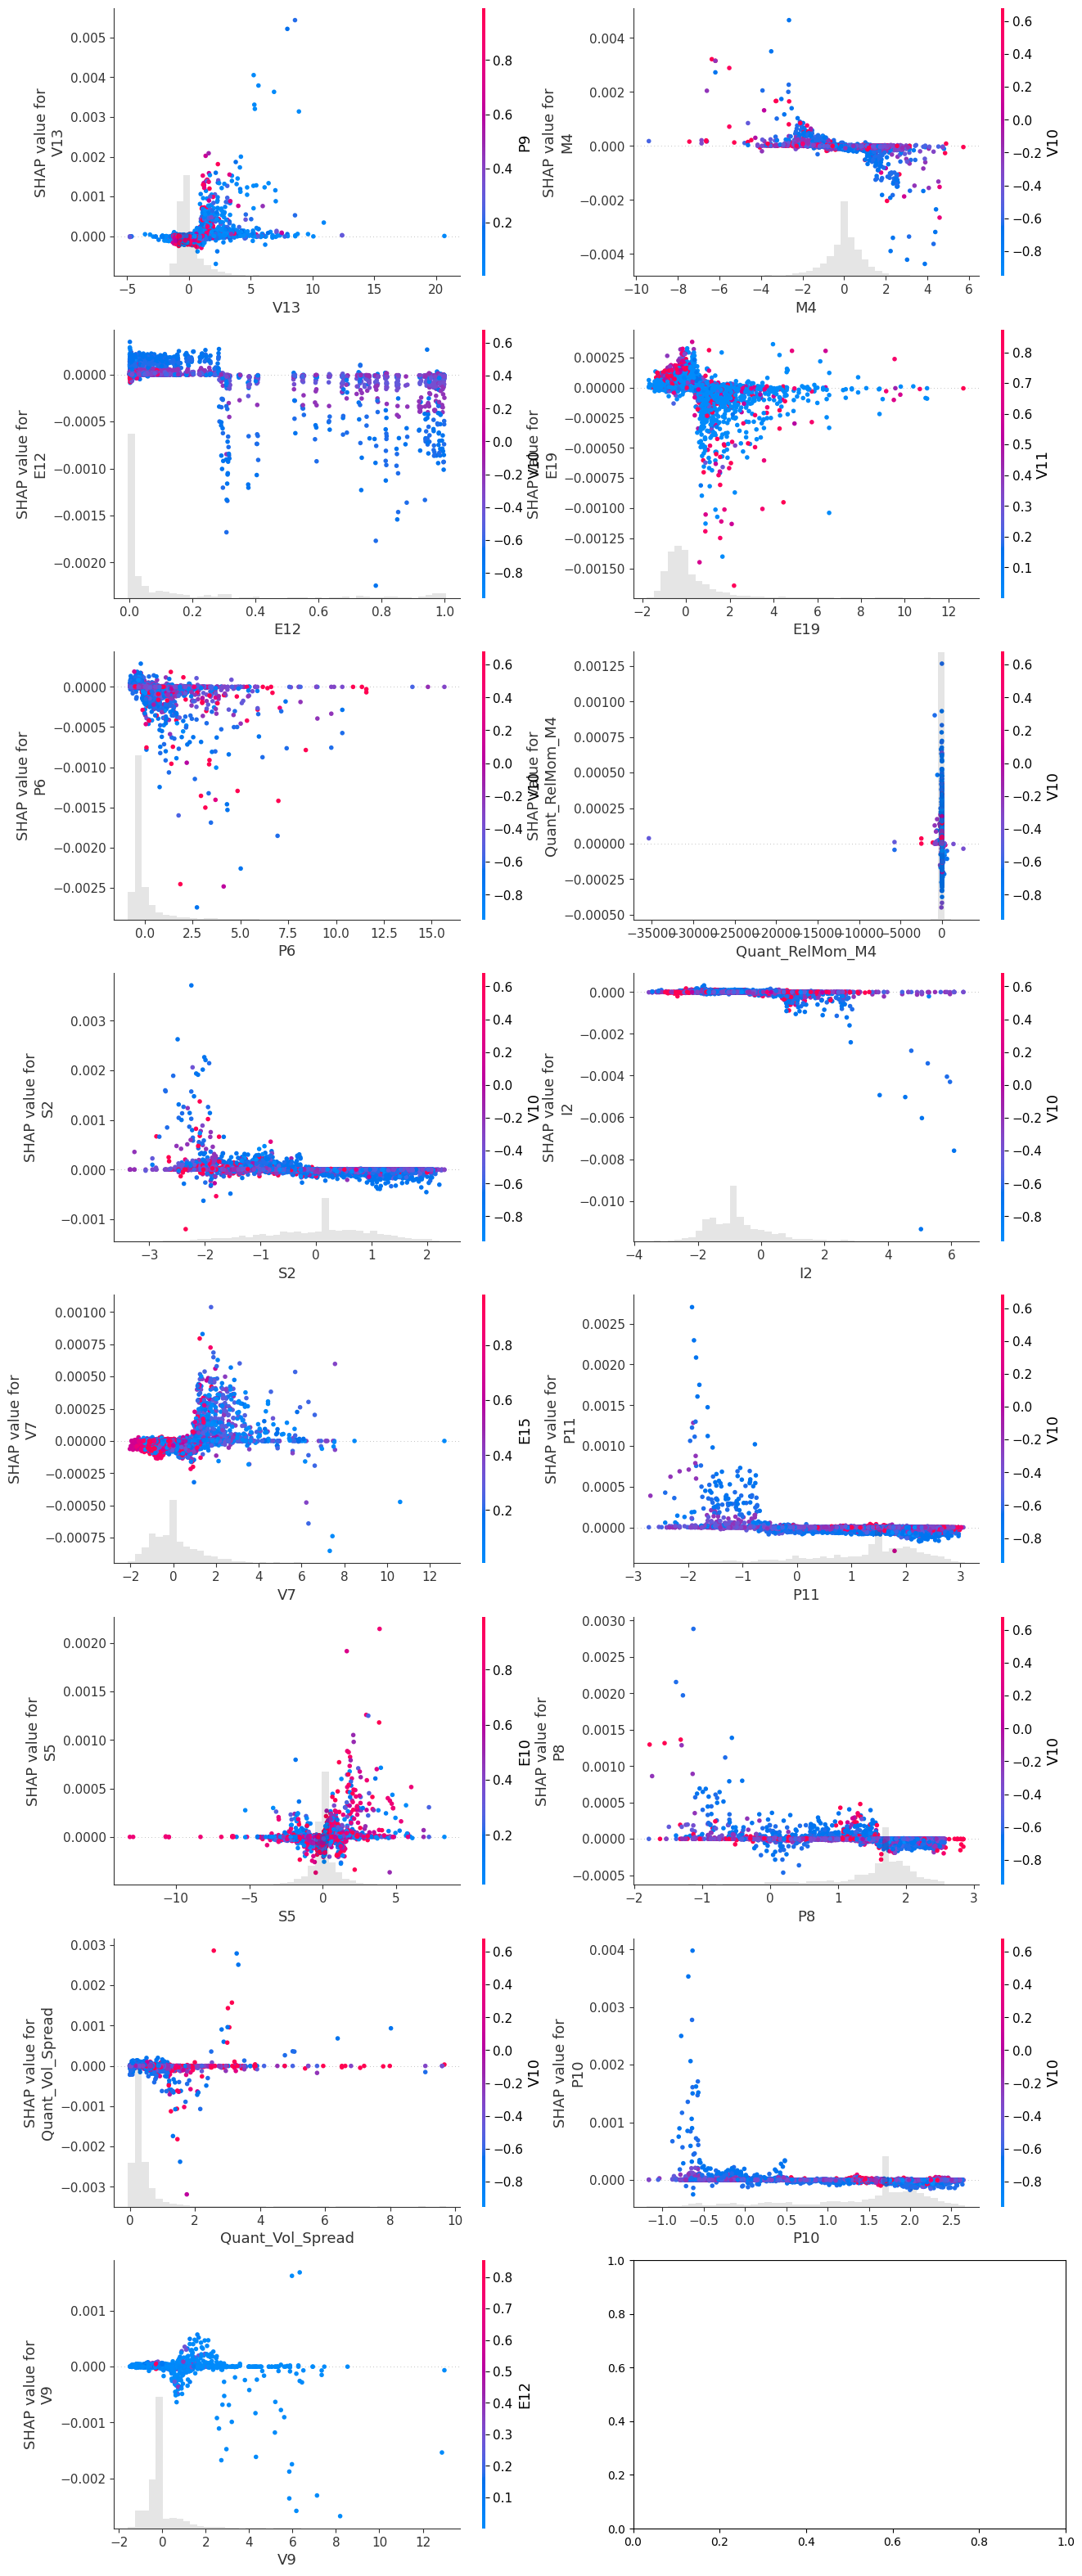

In [40]:
model = lgb.LGBMRegressor(random_state=34, n_jobs=-1, verbose=-1, n_estimators=10000,
                          learning_rate=0.01,
                          colsample_bytree=0.71,
                             min_child_weight=57,
                             reg_lambda=79,
                             reg_alpha=81,
                             subsample=0.67,
                             num_leaves=71,
                             max_depth=130)

callbacks = [lgb.early_stopping(1000, verbose=0)]
fit_params = {"callbacks":callbacks, "eval_metric": "rmse", "sample_weight": "date_id"}

processing = Pipeline([("fe", FeatureEng(u1=False, u2=False, add_ts=False,
                                             riskadj_m4=True, quant_p11=False, fed_model=True,
                                             glob_vol=False, relmom=True, mom_div=False,
                                             mompersistence=False, momregime=True, vol_spread=True,
                                             price_mom=True, rate_sens=False)),
                            ("imputer", tml.DfImputer(strategy="median", fill_value=0)),
                            #("scaler", tml.DfScaler())
                            ])

pipe = Pipeline([("processing", processing),
                ("model", model)])

FEATURES = [c for c in df.columns if c not in DROP]

cvscore = TSCrossValidate(data=df[FEATURES], target=df[TARGET], cv=ts_folds, estimator=pipe, shap=True, imp_coef=True, fit_params=fit_params, early_stopping=True)
oof, res = cvscore.score()

print(res["iterations"])

summary_evaluation(res["folds_eval"], df, factor=555)

tml.plot_feat_imp(data=res["feat_imp"], n=15, imp="both")

to_plot = res["feat_imp"].head(15)["Feature"].to_list()
tml.plot_shap_values(res["shap_values"], features=to_plot)